In [1]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import tv_tensors
from torchvision.transforms import v2

import numpy as np
import matplotlib.pyplot as plt

import os
import PIL
from PIL import Image

In [3]:
import sys

LIB_PATH = '/kaggle/input/od-helper'
sys.path.append(LIB_PATH)

from OD_datasets_kaggle import VOCDetection, OD_transform
from OD_utils import visualize
import S4T as S

In [4]:
train_augs = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomPhotometricDistort(p = 0.5),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_augs = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = OD_transform(500, None, None, train_augs)
test_transform = OD_transform(500, None, None, test_augs)

In [5]:
from typing import Optional, Callable, Tuple, List

class PascalVOC2012(S.SDataModule):
    def __init__(self,
                 train_transforms: Optional[Callable],
                 test_transforms: Optional[Callable],
                 batch_size: int):
        super().__init__()
        self.batch_size = batch_size
        train2007 = VOCDetection('/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2007', image_set = 'train', transforms = train_transforms)
        train2012 = VOCDetection('/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2012', image_set = 'train', transforms = train_transforms)
        self.train_dataset = torch.utils.data.ConcatDataset([train2007, train2012])
        self.val_dataset = VOCDetection('/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2012', image_set = 'val', transforms = test_transforms)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = True,
                                           collate_fn = self.collate_fn,
                                           num_workers = 4,
                                           prefetch_factor = 1)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = False,
                                           collate_fn = self.collate_fn,
                                           num_workers = 4,
                                           prefetch_factor = 1)

    def collate_fn(self, batch):
        img_batch, tar_batch = [], []
        for img, tar in batch:
            img_batch.append(img)
            tar_batch.append(tar)
        return torch.stack(img_batch), tar_batch

In [6]:
data = PascalVOC2012(train_transforms = train_transform,
                     test_transforms = test_transform,
                     batch_size = 32)

In [7]:
class Grid:
    """
    Return the upper-left coordinates of each grid-cell
    """
    def __init__(self,
                 grid_size: Tuple[int, int]):
        self.grid_size = grid_size

    def __call__(self,
                 image: torch.Tensor):
        """
        image: torch.Tensor, shape: (N, *, H, W)
        """
        img_h, img_w = image.shape[-2:]
        grid_cell_h = img_h/self.S_h
        grid_cell_w = img_w/self.S_w
        return grid_cell_h, grid_cell_w

class OffsetCoder:
    def __init__(self, image_size: Tuple[int]):
        self.image_size = image_size

    def decode(self,
               encoded_offsets: torch.Tensor,
               gridcells: torch.Tensor,
               grid_cell_h: float, grid_cell_w: float):
        """
        Decode encoded_offsets and gridcells coordinates to get bounding boxes with the type xywh.
        """
        bboxes = torch.zeros_like(encoded_offsets, device = encoded_offsets.device)
        bboxes[:, 0] = encoded_offsets[:, 0]*grid_cell_w + gridcells[:, 0]
        bboxes[:, 1] = encoded_offsets[:, 1]*grid_cell_h + gridcells[:, 1]
        bboxes[:, 2] = encoded_offsets[:, 2]*self.image_size[1]
        bboxes[:, 3] = encoded_offsets[:, 3]*self.image_size[0]
        return bboxes

    def encode(self,
               boxes: torch.Tensor,
               gridcells: torch.Tensor,
               grid_cell_h: float, grid_cell_w: float):
        """
        Encode boxes given gridcells coordinates.
        """
        bboxes = torch.zeros_like(boxes, device = boxes.device)
        bboxes[:, 0] = (boxes[:, 0]-gridcells[:, 0])/grid_cell_w
        bboxes[:, 1] = (boxes[:, 1]-gridcells[:, 1])/grid_cell_h
        bboxes[:, 2] = boxes[:, 2]/self.image_size[1]
        bboxes[:, 3] = boxes[:, 3]/self.image_size[0]
        return bboxes

def box_iou(boxes1: torch.Tensor,
            boxes2: torch.Tensor,
            box_type: str):
    if box_type == 'cxcywh':
            boxes1 = torchvision.ops.box_convert(boxes1, 'cxcywh', 'xyxy')
            boxes2 = torchvision.ops.box_convert(boxes2, 'cxcywh', 'xyxy')
    return torchvision.ops.box_iou(boxes1, boxes2)

class Resnet18(nn.Module):
    def __init__(self,
                 pretrained: bool = True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.net = torchvision.models.resnet18(pretrained)
        delattr(self.net, "avgpool")
        delattr(self.net, "fc")
    def forward(self, X: torch.Tensor):
        return self.net.layer4(self.net.layer3(self.net.layer2(self.net.layer1(self.net.maxpool(self.net.relu(self.net.bn1(self.net.conv1(X))))))))

In [8]:
class MyYOLO_ResNet18(S.SModule):
    def __init__(self,
                 grid_size: Tuple[int, int],
                 num_classes: int,
                 num_boxes_per_gridcell: int,
                 lr: float):
        super().__init__()
        self.num_classes = num_classes
        self.num_boxes_per_gridcell = num_boxes_per_gridcell
        self.lr = lr
        self.backbone = Resnet18(True)
        self.grid = Grid(grid_size)
        self.box_coder = OffsetCoder(image_size = [500, 500])
        self.predictor = nn.Conv2d(512, num_boxes_per_gridcell*5 + num_classes,
                                   kernel_size = 3, padding = 1)

    def forward(self, X: torch.Tensor):
        out = self.backbone(X)
        out = self.predictor(out).permute(0, 2, 3, 1)
        return torch.sigmoid(out)

In [9]:
@add_to_class(MyYOLO_ResNet18)
def loss(self,
         preds: torch.Tensor,
         targets: List[dict]):
    grid_cell_h, grid_cell_w = self.box_coder.image_size[0]/self.grid.grid_size[0], \
                               self.box_coder.image_size[1]/self.grid.grid_size[1]

    num_foreground = 0
    local_loss = 0
    obj_conf_loss = 0
    noobj_conf_loss = 0
    prob_loss = 0
    for preds_per_img, targets_per_img in zip(preds, targets):                                   # (S, S, (B*5+C)) vs (m, )
        if targets_per_img['boxes'].numel() == 0:
            continue
        shuffle_idxs = torch.randperm(targets_per_img['boxes'].shape[0])
        gt_bboxes_per_img = torchvision.ops.box_convert(targets_per_img['boxes'], 'xyxy', 'cxcywh')[shuffle_idxs]                         # (m, 4)
        gt_logits_per_img = nn.functional.one_hot(targets_per_img['labels']-1, self.num_classes).type(torch.float)[shuffle_idxs]        # (m, C)

        foreground_gc_idxs_per_img = gt_bboxes_per_img[:, :2].clone()
        foreground_gc_idxs_per_img[:, 0] = foreground_gc_idxs_per_img[:, 0]//grid_cell_w
        foreground_gc_idxs_per_img[:, 1] = foreground_gc_idxs_per_img[:, 1]//grid_cell_h
        foreground_gc_idxs_per_img = foreground_gc_idxs_per_img.type(torch.long)

        gc_idxs_per_img = torch.full(preds_per_img.shape[:2], -1,
                                      dtype = torch.long,
                                      device = preds.device)
        gc_idxs_per_img[foreground_gc_idxs_per_img[:, 1], foreground_gc_idxs_per_img[:, 0]] = torch.arange(start = 0,
                                                                                                           end = len(gt_bboxes_per_img),
                                                                                                           dtype = torch.long,
                                                                                                           device = preds.device)
        gt_matched_idxes_per_img = gc_idxs_per_img[gc_idxs_per_img >= 0] # (objs, )
        num_foreground += len(gt_matched_idxes_per_img)
        foreground_preds_per_img = preds_per_img[gc_idxs_per_img >= 0]   # (objs, (B*5+C))
        background_preds_per_img = preds_per_img[gc_idxs_per_img < 0]    # (noobjs, (B*5+C))

        # noobjs
        background_preds_per_img = background_preds_per_img[torch.rand(background_preds_per_img.shape[0],)<0.2]
        noobj_conf_loss += (background_preds_per_img[:, :self.num_boxes_per_gridcell].reshape(-1)**2).sum()

        # objs
        conf_obj_preds_per_img = foreground_preds_per_img[:, :self.num_boxes_per_gridcell]                  # (objs, B)
        offset_preds_per_img = foreground_preds_per_img[:, self.num_boxes_per_gridcell:-self.num_classes]\
                                .reshape(-1, self.num_boxes_per_gridcell, 4)                                # (objs, B, 4)
        prob_preds_per_img = foreground_preds_per_img[:, -self.num_classes:]                                # (objs, C)
        ## prob_loss
        prob_loss += nn.functional.mse_loss(prob_preds_per_img,
                                            gt_logits_per_img[gt_matched_idxes_per_img], reduction = 'sum')
        #prob_loss += nn.functional.binary_cross_entropy(prob_preds_per_img,
        #                                                gt_logits_per_img[gt_matched_idxes_per_img], reduction = 'sum')
        # predict_iou
        max_iou_box_idxs = []
        iou_preds = []
        for foreground_offsets, gt_box, upper_lefts in zip(offset_preds_per_img,
                                                           gt_bboxes_per_img[gt_matched_idxes_per_img],
                                                           foreground_gc_idxs_per_img[gt_matched_idxes_per_img]):
            upper_lefts = upper_lefts*torch.tensor([grid_cell_w, grid_cell_h],
                                                   dtype = preds.dtype,
                                                   device = preds.device).unsqueeze(0).repeat_interleave(self.num_boxes_per_gridcell, dim  = 0)             #
            bbox_preds = self.box_coder.decode(foreground_offsets, upper_lefts, grid_cell_h, grid_cell_w)
            iou_pred, max_idx = box_iou(bbox_preds, gt_box.unsqueeze(0), box_type = 'cxcywh').max(dim = 0)
            iou_preds.append(iou_pred)
            max_iou_box_idxs.append(max_idx)
        ## local_loss
        offset_preds_per_img = offset_preds_per_img[torch.arange(0, len(max_iou_box_idxs)), max_iou_box_idxs, :].reshape(-1, 4)
        gt_offsets_per_img = self.box_coder.encode(gt_bboxes_per_img[gt_matched_idxes_per_img],
                                                   foreground_gc_idxs_per_img[gt_matched_idxes_per_img]*\
                                                   torch.tensor([grid_cell_w, grid_cell_h],
                                                   dtype = preds.dtype,
                                                   device = preds.device),
                                                   grid_cell_h, grid_cell_w)

        local_loss += nn.functional.mse_loss(offset_preds_per_img[:, :2], gt_offsets_per_img[:, :2], reduction = 'sum')\
                    + nn.functional.mse_loss(torch.sqrt(offset_preds_per_img[:, 2:]), torch.sqrt(gt_offsets_per_img[:, 2:]), reduction = 'sum')
        ## obj_conf_loss
        obj_conf_loss += nn.functional.mse_loss(conf_obj_preds_per_img[torch.arange(0, len(max_iou_box_idxs)), max_iou_box_idxs].reshape(-1),
                                                torch.Tensor(iou_preds).to(preds), reduction = 'sum')
        #obj_conf_loss += nn.functional.binary_cross_entropy(conf_obj_preds_per_img[torch.arange(0, len(max_iou_box_idxs)), max_iou_box_idxs].reshape(-1),
        #                                                    torch.Tensor(iou_preds).to(preds), reduction = 'sum')

    N = max(1, num_foreground)
    return local_loss/N, prob_loss/N, obj_conf_loss/N, noobj_conf_loss/N, sum(iou_preds)/len(iou_preds)

In [10]:
@add_to_class(MyYOLO_ResNet18)
def training_step(self, batch, batch_idx):
    x, y = batch
    preds = self.forward(x)
    local_loss, prob_loss, obj_conf_loss, noobj_conf_loss, iou_preds = self.loss(preds, y)
    loss = 5*local_loss + prob_loss + obj_conf_loss + 0.5*noobj_conf_loss
    values = {"train_loss": loss,
              "train_local_los": local_loss,
              "train_prob_loss": prob_loss,
              "train_obj_conf_loss": obj_conf_loss,
              "train_noobj_conf_loss": noobj_conf_loss,
              'train_avg_iou_preds': iou_preds}
    self.log_dict(values, pbar = True, train_logging = True)
    return loss

@add_to_class(MyYOLO_ResNet18)
def validation_step(self, batch, batch_idx):
    x, y = batch
    preds = self.forward(x)
    local_loss, prob_loss, obj_conf_loss, noobj_conf_loss, iou_preds = self.loss(preds, y)
    loss = 5*local_loss + prob_loss + obj_conf_loss + 0.5*noobj_conf_loss
    values = {"val_loss": loss,
              "val_local_los": local_loss,
              "val_prob_loss": prob_loss,
              "val_obj_conf_loss": obj_conf_loss,
              "val_noobj_conf_loss": noobj_conf_loss,
              'val_avg_iou_preds': iou_preds}
    self.log_dict(values, pbar = True, train_logging = False)

@add_to_class(MyYOLO_ResNet18)
def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, weight_decay = 0.00005)
    return optimizer

In [11]:
checkpoint_callback = S.ModelCheckpoint(dirpath = '/kaggle/working',
                                      save_top_k = 7, monitor = 'val_avg_iou_preds',
                                      mode = 'max',
                                      filename = 'mYOLO2-voc-12-epoch:%02d-val_avg_iou_preds:%.4f')

In [12]:
torch.manual_seed(42)

net = MyYOLO_ResNet18(grid_size = (16, 16),
                      num_classes = 20,
                      num_boxes_per_gridcell = 2,
                      lr = 1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [13]:
print('Start training')

trainer = S.Trainer(accelerator="gpu",
                    callbacks = [checkpoint_callback],
                    enable_checkpointing=True,
                    max_epochs = 50)
trainer.fit(net, data, ckpt_path = '/kaggle/input/yolov1-ckpt/mYOLO2-voc-12-epoch_19-val_avg_iou_preds_0.6893.ckpt')

Start training
>> Epoch 49/50: validating... 181/182 [===================>] - 0.26s/step - val_loss: 1.5498 - val_avg_iou_preds: 0.7917 - val_obj_conf_loss: 0.1785 - val_noobj_conf_loss: 0.1582 - val_prob_loss: 0.5247 - val_local_los: 0.1535

defaultdict(list,
            {'train_noobj_conf_loss': [0.12747878808136812,
              0.1530805649924371,
              0.15601394531327928,
              0.15910768772725464,
              0.15915876267485118,
              0.16149324764305514,
              0.16242821987153028,
              0.16279509527326094,
              0.16323534874716622,
              0.16496324921860306,
              0.16777720284949016,
              0.1657139002581051,
              0.16849034879690014,
              0.1653555102849285,
              0.16617665454339425,
              0.1664704051637,
              0.16704345471316273,
              0.16626101303193355,
              0.16592921371705802,
              0.16400343304362278,
              0.16188772269144133,
              0.1602742282912889,
              0.16118256289671368,
              0.1598332638812436,
              0.15701856762750604,
              0.15468064570937176,
              0.15071268127470164,
              0.14781

## Inference

In [14]:
ckpt = torch.load('/kaggle/input/yolov1-ckpt/mYOLO2-voc-12-epoch_21-val_avg_iou_preds_0.7118.ckpt',  map_location = torch.device('cpu'))['state_dict']
net.load_state_dict(ckpt)

<All keys matched successfully>

In [15]:
val_dataset = data.val_dataset
net = net.to('cpu')

In [16]:
def predict(model: nn.Module,
            X: torch.Tensor,
            obj_conf_thres: float,
            cls_conf_thres: float,
            nms_thres: float):
    grid_cell_h, grid_cell_w = model.box_coder.image_size[0]/model.grid.grid_size[0], \
                               model.box_coder.image_size[1]/model.grid.grid_size[1]
    model.eval()
    preds = model(X.unsqueeze(0))
    ## Split general prediction to different specific predictions
    conf_preds = preds[:, :, :, :2]
    offset_preds = preds[:, :, :, 2:10].reshape(1, 16, 16, 2, 4)
    prob_preds = preds[:, :, :, 10:]

    max_conf_preds, max_conf_pred_idxs = conf_preds.max(dim = -1)
    grid_cell_idxs = torch.where(max_conf_preds > obj_conf_thres)

    ## Get reliable predictions
    reliable_class_probs = prob_preds[grid_cell_idxs]
    max_reliable_class_probs, max_class_idxs = reliable_class_probs.max(dim = -1)
    reliable_offsets = offset_preds[grid_cell_idxs][torch.arange(0, len(max_reliable_class_probs)), max_conf_pred_idxs[max_conf_preds > obj_conf_thres], :]
    
    upper_lefts = torch.stack([grid_cell_idxs[2], grid_cell_idxs[1]]).T*torch.tensor([grid_cell_w, grid_cell_h])
    reliable_predicted_boxes = torchvision.ops.box_convert(model.box_coder.decode(reliable_offsets, upper_lefts, grid_cell_h, grid_cell_w), 'cxcywh', 'xyxy')
    
    ##
    confidence_scores = max_reliable_class_probs*max_conf_preds[grid_cell_idxs]
    kept_box_idxs = torchvision.ops.nms(reliable_predicted_boxes, confidence_scores, 
                                        iou_threshold = nms_thres)
    confidence_scores = confidence_scores[kept_box_idxs]
    predicted_classes = max_class_idxs[kept_box_idxs][confidence_scores > cls_conf_thres]
    predicted_boxes = reliable_predicted_boxes[kept_box_idxs][confidence_scores > cls_conf_thres]
    confidence_scores = confidence_scores[confidence_scores > cls_conf_thres]
    return {'class_idxs': predicted_classes,
            'confidence_scores': confidence_scores,
            'predicted_boxes': predicted_boxes}

In [17]:
from OD_datasets import VOC_I2N, VOC_N2I

torch.uint8


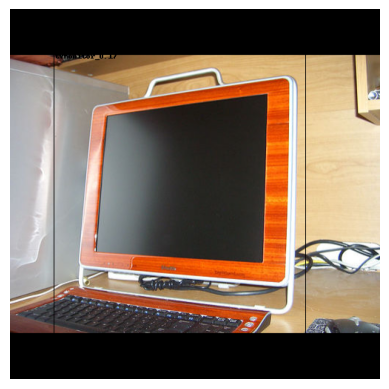

In [18]:
preds = predict(net, val_dataset[4][0], 0.15, 0.15, 0.5)
visualize(val_dataset[4][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


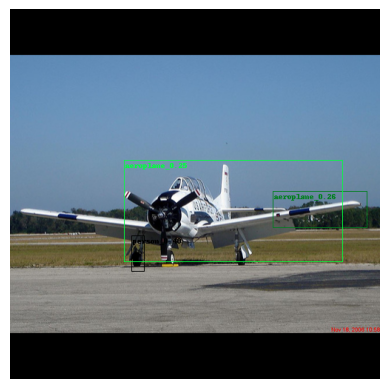

In [19]:
preds = predict(net, val_dataset[5][0], 0.15, 0.15, 0.5)
visualize(val_dataset[5][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


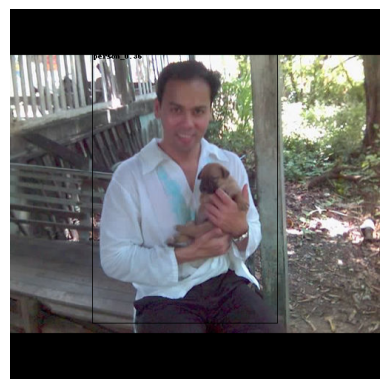

In [20]:
preds = predict(net, val_dataset[6][0], 0.15, 0.15, 0.5)
visualize(val_dataset[6][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


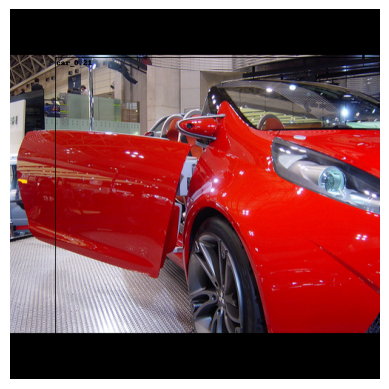

In [21]:
preds = predict(net, val_dataset[7][0], 0.15, 0.1, 0.5)
visualize(val_dataset[7][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


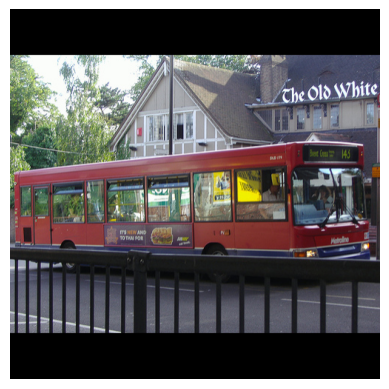

In [22]:
preds = predict(net, val_dataset[8][0], 0.1, 0.1, 0.5)
visualize(val_dataset[8][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


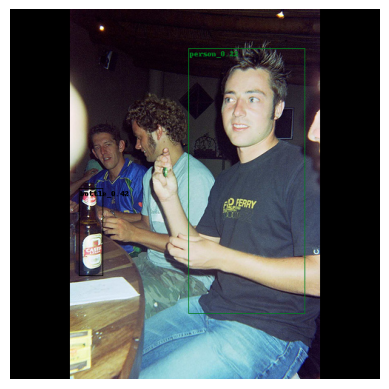

In [23]:
preds = predict(net, val_dataset[9][0], 0.15, 0.15, 0.3)
visualize(val_dataset[9][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


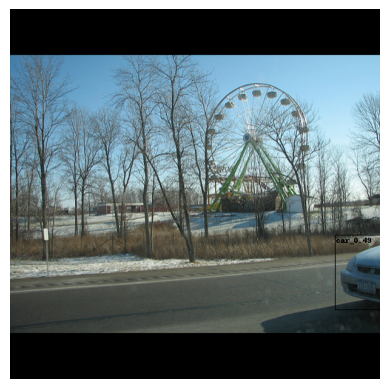

In [24]:
preds = predict(net, val_dataset[10][0], 0.15, 0.15, 0.3)
visualize(val_dataset[10][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


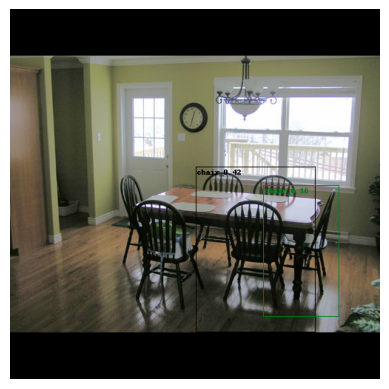

In [25]:
preds = predict(net, val_dataset[11][0], 0.15, 0.15, 0.5)
visualize(val_dataset[11][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


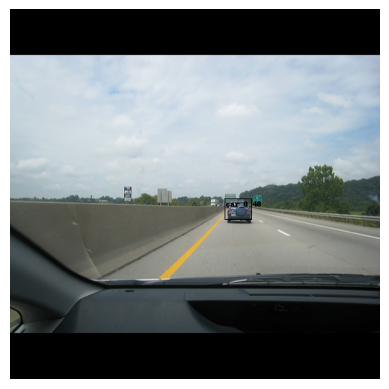

In [26]:
preds = predict(net, val_dataset[12][0], 0.15, 0.15, 0.4)
visualize(val_dataset[12][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


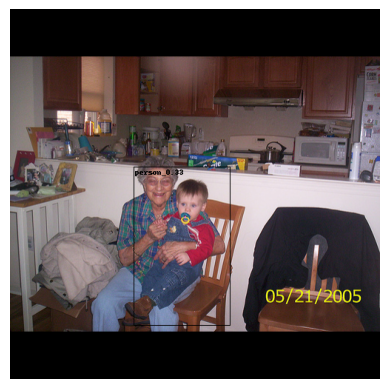

In [27]:
preds = predict(net, val_dataset[13][0], 0.1, 0.15, 0.5)
visualize(val_dataset[13][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


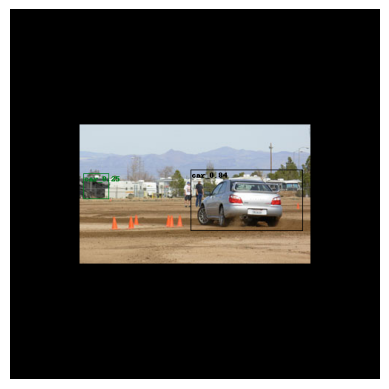

In [28]:
preds = predict(net, val_dataset[14][0], 0.1, 0.15, 0.5)
visualize(val_dataset[14][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


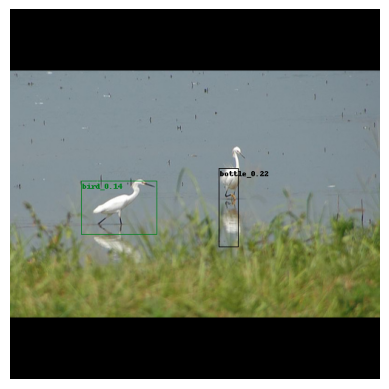

In [29]:
preds = predict(net, val_dataset[15][0], 0.1, 0.1, 0.5)
visualize(val_dataset[15][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


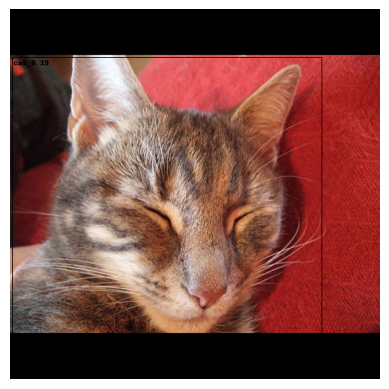

In [30]:
preds = predict(net, val_dataset[16][0], 0.1, 0.1, 0.5)
visualize(val_dataset[16][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


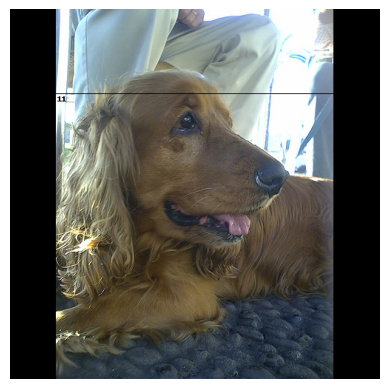

In [31]:
preds = predict(net, val_dataset[17][0], 0.1, 0.1, 0.5)
visualize(val_dataset[17][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


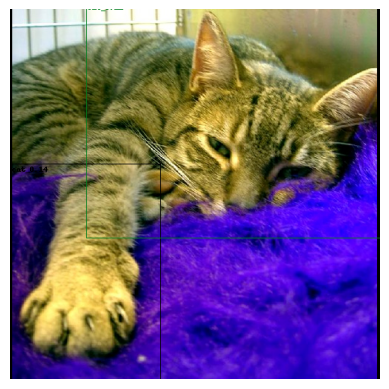

In [32]:
preds = predict(net, val_dataset[18][0], 0.1, 0.1, 0.5)
visualize(val_dataset[18][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


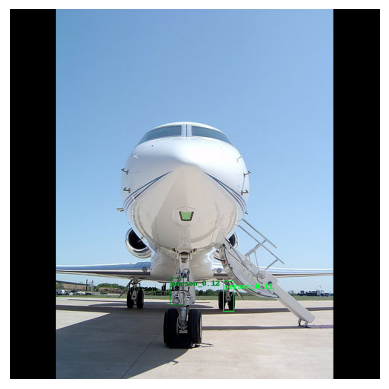

In [33]:
preds = predict(net, val_dataset[19][0], 0.1, 0.1, 0.5)
visualize(val_dataset[19][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


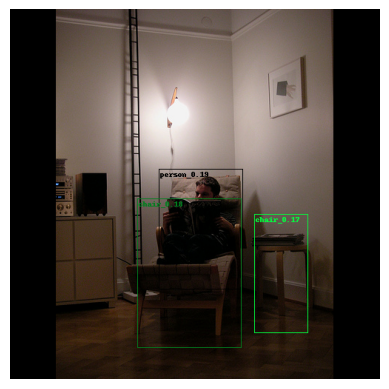

In [34]:
preds = predict(net, val_dataset[20][0], 0.1, 0.1, 0.5)
visualize(val_dataset[20][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])